# Mask R-CNN - Inspect Brain Tissue Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [687]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import cv2 as cv
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import brain

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [2]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [688]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "samples/braintissue/datasets/brainseg")

# Inference Configuration
config = brain.BrainsegInferenceConfig()

## Notebook Preferences

In [689]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [690]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Model

In [691]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [692]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /Documents/BrainSegmentation_v1/Mask_RCNN/logs/brainseg20181215T1510/mask_rcnn_brainseg_0040.h5
Re-starting from epoch 40


## Run Detection

In [648]:
def check_valid(mat, x,y, size):
    check = []
    
    if(x==0):
        if(y==0):
            for i in range(len(mat)):
                if( (mat[i][0] > (size/16)*14) | (mat[i][1] >= (size/16)*14)  ):
                    check.append(False)
                else:
                    check.append(True)
        else:
            #
            for i in range(len(mat)):
                if( (mat[i][0] < (size/16)*2) | (mat[i][0] >= (size/16)*14) | (mat[i][1] >= (size/16)*14) ):
                    check.append(False)
                else:
                    check.append(True)
    else:
        if(y==0):
            for i in range(len(mat)):
                if( (mat[i][0] > (size/16)*14) | (mat[i][1] >= (size/16)*14) | (mat[i][1] < (size/16))  ):
                    check.append(False)
                else:
                    check.append(True)
        else:
            #
            for i in range(len(mat)):
                if( (mat[i][0] < (size/16)*2) | (mat[i][0] >= (size/16)*14) | (mat[i][1] < (size/16)*2) | (mat[i][1] >= (size/16)*14)  ):
                    check.append(False)
                else:
                    check.append(True)
    
    return check

In [663]:
def scale_boxes(boxes,x,y, size):
    new_boxes = np.zeros((len(boxes),4))
    for i in range(len(boxes)):
        
        new_boxes[i][0] = boxes[i][0] + size*y*3/4
        new_boxes[i][1] = boxes[i][1] + size*x*3/4
        new_boxes[i][2] = boxes[i][2] + size*y*3/4
        new_boxes[i][3] = boxes[i][3] + size*x*3/4
    
    return new_boxes

In [664]:
def scale_masks(masks, x, y , size, width_img, height_img):
    
    overlap_size = int(size*3/4)
    new_mask = np.full((height_img, width_img, masks.shape[2]), False)
    for i in range(masks.shape[2]):
        
        new_mask[y*overlap_size:y*overlap_size+size, x*overlap_size:x*overlap_size+size,i] = masks[:,:,i]
    return new_mask

In [696]:
dataset = "datasets/brainseg"
folder_img = "Test"


In [719]:
wafer_intensity = "wafer_1_downsized_3_intensityCorrected.tif"
path_image_intensity = os.path.join(dataset,folder_img,wafer_intensity)
wafer_magFluo = "wafer_1_downsized_3_magFluo.tif"
path_image_fluo = os.path.join(dataset,folder_img,wafer_magFluo)

In [720]:
img_intensity = skimage.io.imread(path_image_intensity)
img_fluo = skimage.io.imread(path_image_fluo)

In [721]:
width = img_intensity.shape[1]
height = img_intensity.shape[0]

In [724]:
if len(img_intensity.shape) == 2:
    img_intensity = img_intensity[:, :, np.newaxis]

if len(img_fluo.shape) == 2:
    img_fluo = img_fluo[:, :, np.newaxis]

In [725]:
image = np.dstack((img_intensity, img_intensity,img_fluo))

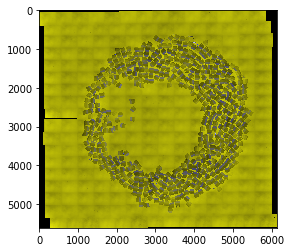

In [727]:
plt.imshow(image)

In [728]:
image.shape

(5616, 6136, 3)

To select the right detections boxes we will overlap every 2 images.

The overlapping image crop will start at the (3/4)*size of the image.

In [651]:
# Calculate the number of overlapping crops 
# We substract the first one (-1024) as it does not overlap 
nb_crop_x = int((image.shape[1]-1024) // (1024*3/4) )

6

In [652]:
# Calculate the number of overlapping crops 
# We substract the first one (-1024) as it does not overlap 
nb_crop_y = int((image.shape[0]-1024) // (1024*3/4) )
nb_crop_y

5

In [677]:
crop_size = 1024
# Size of the image without the lasts crops which will have a specific size
size_x = int(crop_size + crop_size*3/4*nb_crop_x)
size_y = int(crop_size + crop_size*3/4*nb_crop_y)
# Offset to start the cropping in the full image
offset = 1024

In [678]:
list_rois = []
list_class = []
list_scores = []
list_masks = []

full_crop = image[offset:offset+size_y,offset:offset+size_x]

crop_step = int(crop_size*3/4)

for ind_x in range(nb_crop_x+1):
    for ind_y in range(nb_crop_y+1):
        # Crop image
        crop = image[offset+ind_y*crop_step:offset+ind_y*crop_step+crop_size ,offset+ ind_x*crop_step:offset+ind_x*crop_step+crop_size]
        # Generate the detection
        r = model.detect([crop], verbose=0)[0]
        # Check the bounding boxes to select only the bbox proper to each image and let the overlapped one
        # be detected by the next crop
        valid_mask = check_valid(r['rois'],ind_x, ind_y,crop_size)
        
        # Add the components of the detection
        # Scale the bbox coordinates from the normalized crop coordinates (0 --> 1024)
        # to the width/height of the full image
        list_rois.append(scale_boxes(r['rois'][valid_mask],ind_x,ind_y,crop_size) )
        list_class.append(r['class_ids'][valid_mask].reshape(-1,1))
        list_scores.append(r['scores'][valid_mask].reshape(-1,1))
        # Create the masks images from the normalized crop coordinates (0 --> 1024)
        # to the width/height of the full image
        list_masks.append(scale_masks(r['masks'][:,:,valid_mask],ind_x, ind_y,crop_size, size_x,size_y ) )
        
        
full_rois = np.vstack(list_rois)
full_class = np.vstack(list_class).reshape(-1)
full_scores = np.vstack(list_scores).reshape(-1)
full_masks = np.dstack(list_masks)
   

In [675]:
class_names = ['BG', 'tissue', 'mag']

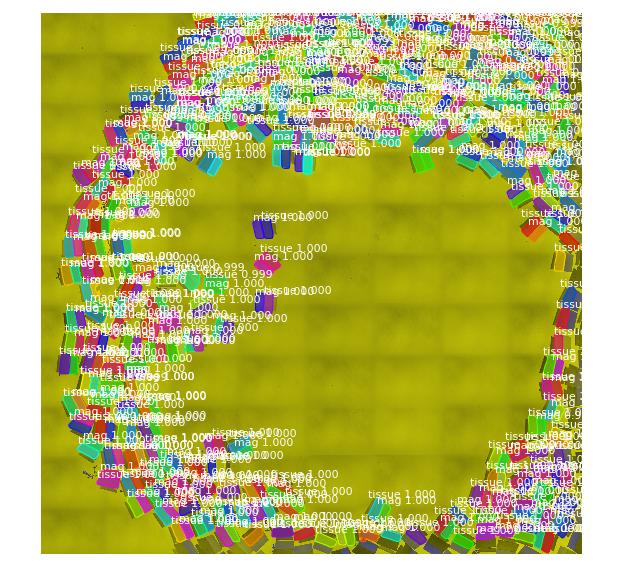

In [679]:
visualize.display_instances(full_crop, full_rois, full_masks, full_class, class_names, full_scores, figsize=(10,10), show_bbox=False )